# SNPS ANALYSIS OF MOUSE RIBOSOME PROFILING AND RNA-SEQ DATA

In [190]:
import gzip
import pandas as pd
import numpy as np
import scipy as sp
import os

from multiprocessing import Pool
from matplotlib import pyplot as plt
from functools import reduce

import pickle

# We use rpy2 for the prop.test and padjust in R
import rpy2
from rpy2 import robjects
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr


from IPython.display import display, HTML

In [2]:
%load_ext rpy2.ipython
%matplotlib inline

plt.rcParams['figure.figsize'] = [16, 8]

## Constants

In [553]:
# The values of the confidence interval coming from the proptest
# must be less than this value
PROPTEST_ERROR_THRESHOLD = 0.05

# After adjusting the p-values of the proptest
# we pick the FDR values less than this threshold
FDR_THRESHOLD = 0.2

## Input & Output Folders

In [11]:
INPUT_FOLDER  = ".."
OUTPUT_FOLDER = "snp_dataframes"

if not os.path.isdir(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

In [5]:
# RNA_SEQ EXPERIMENTS
# Note that we excluded the experiment 20210607-RNAseq-4cell-cross-B

rnaseq_one_cell_exps = [
"20210607-RNAseq-1cell-cross-A",
"20210607-RNAseq-1cell-cross-B",
"20210607-RNAseq-1cell-cross-C",
"20210607-RNAseq-1cell-cross-D"]

rnaseq_two_cell_exps = [
"20210607-RNAseq-2cell-cross-A",
"20210607-RNAseq-2cell-cross-B",
"20210607-RNAseq-2cell-cross-C",
"20210607-RNAseq-2cell-cross-D"
]

rnaseq_four_cell_exps = [
"20210607-RNAseq-4cell-cross-A",
#"20210607-RNAseq-4cell-cross-B",
"20210607-RNAseq-4cell-cross-C"
]

rnaseq_eight_cell_exps = [
"20210607-RNAseq-8cell-cross-A",
"20210607-RNAseq-8cell-cross-B",
"20210607-RNAseq-8cell-cross-C",
"20210607-RNAseq-8cell-cross-D"
]

rnaseq_gv_epxs = [
"20210607-RNAseq-GV-A",
"20210607-RNAseq-GV-B",
"20210607-RNAseq-GV-C",
"20210607-RNAseq-GV-D"
]

rnaseq_mii_exps = [
"20210607-RNAseq-MII-A",
"20210607-RNAseq-MII-B",
"20210607-RNAseq-MII-C",
"20210607-RNAseq-MII-D"
]

rnaseq_all_exps = rnaseq_one_cell_exps + rnaseq_two_cell_exps + \
                  rnaseq_four_cell_exps + rnaseq_eight_cell_exps +\
                  rnaseq_gv_epxs + rnaseq_mii_exps

In [8]:
## RIBOSOME PROFILING EXPERIMENTS

riboseq_one_cell_exps = [
"20210513-ITP-1cell-cross-50-A",
"20210513-ITP-1cell-cross-50-B",
"20210513-ITP-1cell-cross-50-C",
"20210513-ITP-1cell-cross-50-D",
"20210513-ITP-1cell-cross-50-E"]
    
riboseq_two_cell_exps = [
"20210513-ITP-2cell-cross-50-B",
"20210513-ITP-2cell-cross-50-C",
"20210513-ITP-2cell-cross-50-F",
]

riboseq_four_cell_exps = [
"20210513-ITP-4cell-cross-50-B",
"20210513-ITP-4cell-cross-50-C",
"20210513-ITP-4cell-cross-50-D",
]
    
riboseq_eigth_cell_exps = [
"20210513-ITP-8cell-cross-50-A",
"20210513-ITP-8cell-cross-50-B",
"20210513-ITP-8cell-cross-50-C",
"20210513-ITP-8cell-cross-50-D",
]
    
    
riboseq_mii_exps = [
"20210301-ITP-MII-25-B",
"20210301-ITP-MII-50-A",
"20210301-ITP-MII-50-B",
"20210318-ITP-MII-50-B",
#"20210614-ITP-MII-50-A",
#"20210614-ITP-MII-50-B",
#"20210614-ITP-MII-50-C",
"20210614-ITP-MII-50-D",
#"20210614-ITP-MII-50-E",
#"20210614-ITP-MII-50-F",
]    
    
    
riboseq_gv_epxs = [
"20210614-ITP-GV-50-A",
"20210614-ITP-GV-50-B",
"20210614-ITP-GV-50-C",
"20210614-ITP-GV-50-D",
"20210614-ITP-GV-50-E",
"20210614-ITP-GV-50-F",
]

riboseq_all_exps = riboseq_one_cell_exps  + riboseq_two_cell_exps + \
                   riboseq_four_cell_exps + riboseq_eigth_cell_exps + \
                   riboseq_mii_exps       + riboseq_gv_epxs

In [44]:
## FUNCTIONS TO READ SNP FILES

In [9]:
def extract_CDS(name_str):
    """
    Returns CDS boundaries from the transcript header
    """
    
    contents = name_str.split("|")
    
    for c in contents:
        if c.startswith("CDS"):
            boundaries = c.split(":")[1].split("-")
            return (int(boundaries[0]), int(boundaries[1]))
    
    print(name_str)
    raise ValueError 
    
    
    
############################################################
    
    
    
def get_df(snp_count_file):
    """
    Reads SNP cont file into a dataframe
    """
    
    count_df         = pd.read_csv(snp_count_file, sep = "\t")
    transcript_names = list( map( lambda x: x.split("|")[4], count_df["transcript"]) )

    boundaries       = list( map(extract_CDS, count_df["transcript"])  )

    start_positions  = list( map(lambda x: x[0], boundaries ) )
    stop_positions   = list( map(lambda x: x[1], boundaries ) )

    snp_total = count_df["A"] + count_df["C"] + count_df["G"] +  count_df["T"]

    count_df["transcript"] = transcript_names
    count_df["snp_total"]  = snp_total
    count_df["CDS_start"]  = start_positions
    count_df["CDS_stop"]   = stop_positions


    count_df.sort_values(by = ['snp_total'], ascending=False, inplace=True)
    
    return count_df    

#################################################################

def get_ref_alt_counts(count_df):
    """
    Extracts the reference (maternal) and alternative (paternal) 
    counts from the dataframes
    """
    
    ref_count   = 0
    alt_count   = 0
    total_count = 0
    
    cds_ref_count   = 0
    cds_alt_count   = 0
    cds_total_count = 0

    for index, row in count_df.iterrows():
        total_count += row["A"] + row["C"] + row["G"] + row["T"]
        ref_count   += row[ row["REF"] ]
        alt_count   += row[ row["ALT"] ]
        
        if row["position"] >= row["CDS_start"] and\
           row["position"] <= row["CDS_stop"]:
                cds_total_count += row["A"] + row["C"] + row["G"] + row["T"]
                cds_ref_count   += row[ row["REF"] ]
                cds_alt_count   += row[ row["ALT"] ]            

        
    return {"ref_count":     ref_count,     "alt_count": alt_count,         "total_count": total_count,
            "cds_ref_count": cds_ref_count, "cds_alt_count": cds_alt_count, "cds_total_count": cds_total_count}

## RNA-Seq SNP Calls

We read SNP calls from RNA-Seq into dataframes.

In [12]:
rnaseq_experiment_dfs = dict()

for e in rnaseq_all_exps:
    this_file = os.path.join( INPUT_FOLDER, "snp_counts_rnaseq", e + ".tsv.gz")
    rnaseq_experiment_dfs[e] = get_df(this_file)
    rnaseq_experiment_dfs[e]["experiment"] = e
    
rnaseq_reference_alt_counts = dict()

with Pool(4) as p:
    rnaseq_counts_array = p.map( get_ref_alt_counts, [ rnaseq_experiment_dfs[e] for e in rnaseq_all_exps ] )
    
for i in range(len(rnaseq_all_exps)):
    rnaseq_reference_alt_counts[rnaseq_all_exps[i]] = rnaseq_counts_array[i]
    


In [47]:
#Uncomment to get the count
#for e in rnaseq_all_exps:
#    print(e)
#    print(rnaseq_reference_alt_counts[e])

In [13]:
rnaseq_snp_count_df  = pd.DataFrame.from_dict(rnaseq_reference_alt_counts).transpose()
rnseq_snp_count_file = os.path.join(OUTPUT_FOLDER, "rnaseq_experimentwise_snp_counts.csv")
rnaseq_snp_count_df.to_csv(rnseq_snp_count_file)

rnaseq_snp_count_df[:2]

,ref_count,alt_count,total_count,cds_ref_count,cds_alt_count,cds_total_count
20210607-RNAseq-1cell-cross-A,179914,314,180540,179914,314,180540
20210607-RNAseq-1cell-cross-B,180976,373,181700,180976,373,181700


In [14]:
def calculate_ref_alt_percentages(count_dict):
    ref_percentage = (count_dict["ref_count"] / count_dict["total_count"] ) * 100
    alt_percentage = (count_dict["alt_count"] / count_dict["total_count"] ) * 100
    
    cds_ref_percentage = (count_dict["cds_ref_count"] / count_dict["cds_total_count"] ) * 100
    cds_alt_percentage = (count_dict["cds_alt_count"] / count_dict["cds_total_count"] ) * 100
    
    return {"ref_percentage": ref_percentage, "alt_percentage" : alt_percentage,
           "cds_ref_percentage": cds_ref_percentage, "cds_alt_percentage" : cds_alt_percentage}

In [15]:
def calculate_ref_alt_percentages(count_dict):
    ref_percentage = (count_dict["ref_count"] / count_dict["total_count"] ) * 100
    alt_percentage = (count_dict["alt_count"] / count_dict["total_count"] ) * 100
    
    cds_ref_percentage = (count_dict["cds_ref_count"] / count_dict["cds_total_count"] ) * 100
    cds_alt_percentage = (count_dict["cds_alt_count"] / count_dict["cds_total_count"] ) * 100
    
    return {"ref_percentage": ref_percentage, "alt_percentage" : alt_percentage,
           "cds_ref_percentage": cds_ref_percentage, "cds_alt_percentage" : cds_alt_percentage}

In [16]:
rnaseq_reference_alt_percentages = dict()

for e in rnaseq_all_exps:
    rnaseq_reference_alt_percentages[e] = calculate_ref_alt_percentages(rnaseq_reference_alt_counts[e])

In [52]:
# Uncomment to seethe percentages

# for e in rnaseq_all_exps:
#    print(e)
#    print("Alt: {:.1f}    Ref: {:.1f}".format( rnaseq_reference_alt_percentages[e]["cds_alt_percentage"],
#                                       rnaseq_reference_alt_percentages[e]["cds_ref_percentage"]))

In [17]:
rnaseq_experiment_dfs["20210607-RNAseq-4cell-cross-C"][:5]

,transcript,position,REF,ALT,A,C,G,T,snp_total,CDS_start,CDS_stop,experiment
68514,Rps19-203,303,C,T,1,521,1,616,1139,298,735,20210607-RNAseq-4cell-cross-C
66330,Dppa3-201,290,A,C,691,403,1,0,1095,114,566,20210607-RNAseq-4cell-cross-C
4478,Rps26-201,299,C,T,0,505,0,517,1022,270,617,20210607-RNAseq-4cell-cross-C
66329,Dppa3-201,263,C,T,0,509,0,437,946,114,566,20210607-RNAseq-4cell-cross-C
23498,Rpl15-202,275,A,G,441,0,474,0,915,120,734,20210607-RNAseq-4cell-cross-C


## SNP Bar Charts: A Global Look at the SNPs

In [18]:
def get_barplot_df(percentage_df, experiments, cds = False):
    """
    If cds=True, then only SNPS comig from CDS are taken
    if cds=False
    SNPs coming from the ENTIRE transcript are taken
    """
    
    reference_alt_percentages = percentage_df
    
    percentage_dict = {"Experiment": experiments,  "Paternal": [], "Maternal": [], "Other": []}
    
    if cds:
        key_prefix = "cds_"
    else:
        key_prefix = ""
            

    for e in experiments:
        #print(e)
        percentage_dict["Maternal"].append( reference_alt_percentages[e][ key_prefix + "ref_percentage"]) 
        percentage_dict["Paternal"].append( reference_alt_percentages[e][key_prefix + "alt_percentage"]) 
        other = 100 - (reference_alt_percentages[e][key_prefix + "ref_percentage"] +\
                       reference_alt_percentages[e][key_prefix + "alt_percentage"])
        percentage_dict["Other"].append(other)

        #print("Alt: {:.1f}    Ref: {:.1f} Other: {:.1f}".format( \
        #                                   reference_alt_percentages[e][key_prefix + "alt_percentage"],
        #                                   reference_alt_percentages[e][key_prefix + "ref_percentage"],
        #                                   other                ))
    
    
    p_df = pd.DataFrame(percentage_dict, index=experiments)
    
    return p_df

In [19]:
rnaseq_cds_barplot_df = \
    get_barplot_df(percentage_df = rnaseq_reference_alt_percentages, 
                   experiments   = rnaseq_all_exps, 
                   cds           = True)

rnaseq_cds_barplot_df.set_index(keys = "Experiment", inplace = True)

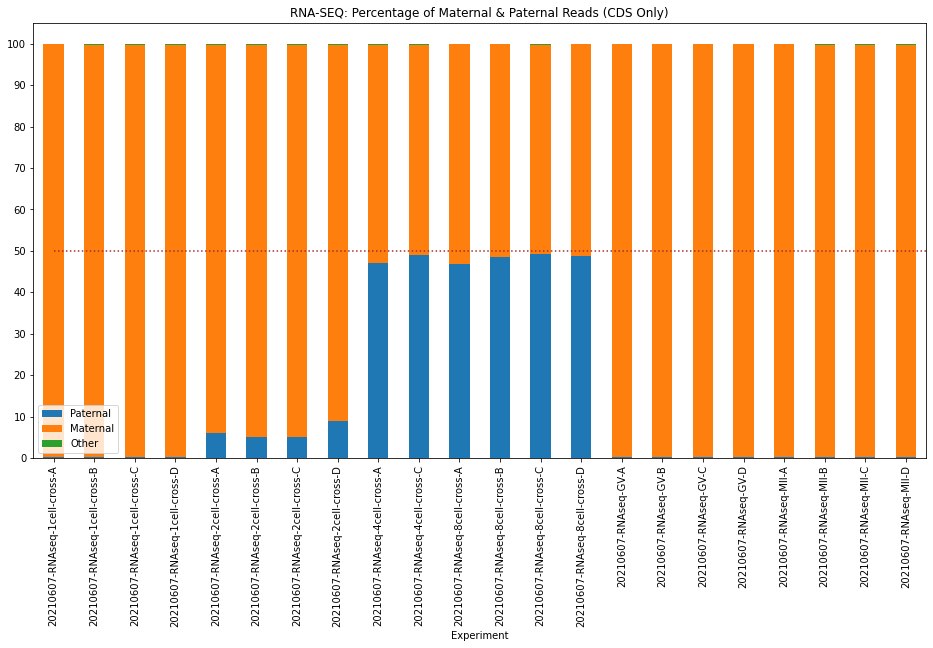

In [20]:
fig  = rnaseq_cds_barplot_df.plot(kind    = "bar", 
                                  stacked = True, 
                                  title   = "RNA-SEQ: Percentage of Maternal & Paternal Reads (CDS Only)");

plt.hlines(50, xmin=0, xmax=len(rnaseq_all_exps), linestyle=':', color="brown" );
plt.yticks(list(range(0,110, 10) ));

In [626]:
np.mean(rnaseq_cds_barplot_df.loc[ rnaseq_mii_exps]["Maternal"])

99.6044638891961

In [21]:
# OUTPUT THE RNASEQ SNP PERCENTAGES FILE
rnaseq_snp_percentages_file = os.path.join(OUTPUT_FOLDER, "rnaseq_snp_percentages.csv")
rnaseq_cds_barplot_df.to_csv(rnaseq_snp_percentages_file)

In [22]:
! cat snp_dataframes/rnaseq_snp_percentages.csv | head -n 3

Experiment,Paternal,Maternal,Other
20210607-RNAseq-1cell-cross-A,0.17392267641519885,99.65326243491747,0.1728148886673324
20210607-RNAseq-1cell-cross-B,0.20528343423225096,99.60154100165107,0.1931755641166717


## Ribosome Profiling SNP Calls

In [25]:
riboseq_experiment_dfs = dict()

for e in riboseq_all_exps:
    this_file = os.path.join(INPUT_FOLDER,"snp_counts_riboseq", e + ".tsv.gz")
    riboseq_experiment_dfs[e] = get_df(this_file)
    riboseq_experiment_dfs[e]["experiment"] = e
    

riboseq_reference_alt_counts = dict()

with Pool(4) as p:
    riboseq_counts_array = p.map( get_ref_alt_counts, [ riboseq_experiment_dfs[e] for e in riboseq_all_exps ] )
    
for i in range(len(riboseq_all_exps)):
    riboseq_reference_alt_counts[riboseq_all_exps[i]] = riboseq_counts_array[i]

riboseq_reference_alt_percentages = dict()

for e in riboseq_all_exps:
    riboseq_reference_alt_percentages[e] = calculate_ref_alt_percentages(riboseq_reference_alt_counts[e])

In [26]:
#for e in riboseq_all_exps:
#    print(e)
#    print("Alt: {:.1f}    Ref: {:.1f}".format( riboseq_reference_alt_percentages[e]["cds_alt_percentage"],
# 

In [27]:
riboseq_barplot_cds_df = \
    get_barplot_df(percentage_df = riboseq_reference_alt_percentages, 
                   experiments   = riboseq_all_exps, 
                   cds           = True)

riboseq_barplot_cds_df.set_index(keys = "Experiment")



,Paternal,Maternal,Other
Experiment,,,
20210513-ITP-1cell-cross-50-A,1.256003,96.983130,1.760867
20210513-ITP-1cell-cross-50-B,0.932685,97.556772,1.510543
20210513-ITP-1cell-cross-50-C,1.015572,96.750169,2.234259
20210513-ITP-1cell-cross-50-D,1.171606,96.388697,2.439697
20210513-ITP-1cell-cross-50-E,1.323877,96.028369,2.647754
20210513-ITP-2cell-cross-50-B,11.798689,86.523720,1.677591
20210513-ITP-2cell-cross-50-C,4.806034,93.017241,2.176724
20210513-ITP-2cell-cross-50-F,7.081090,90.438897,2.480013
20210513-ITP-4cell-cross-50-B,43.879685,52.678141,3.442175


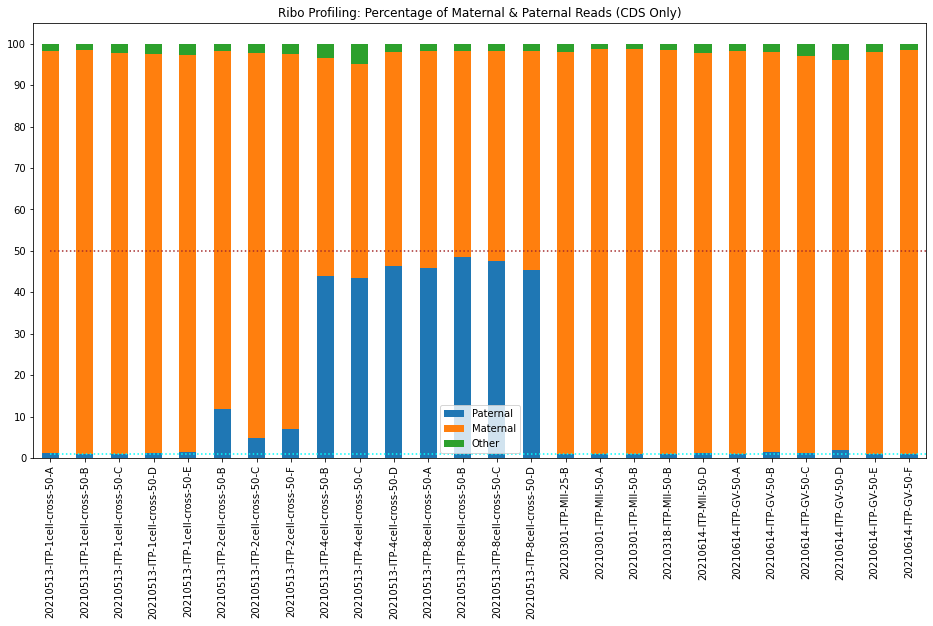

In [28]:
fig  = riboseq_barplot_cds_df.plot(kind    = "bar", 
                                  stacked = True, 
                                  title   = "Ribo Profiling: Percentage of Maternal & Paternal Reads (CDS Only)");

plt.hlines(50, xmin=0, xmax=len(riboseq_all_exps), linestyle=':', color="brown" );
plt.hlines(1, xmin=0, xmax=len(riboseq_all_exps), linestyle=':', color="cyan" );
plt.yticks(list(range(0,110, 10) ));

In [618]:
np.mean(riboseq_barplot_cds_df.loc[ riboseq_mii_exps]["Maternal"]) 

97.33063531080667

In [621]:
np.mean(riboseq_barplot_cds_df.loc[ riboseq_two_cell_exps]["Paternal"]) 

7.895271139261166

In [623]:
np.mean(riboseq_barplot_cds_df.loc[ riboseq_eigth_cell_exps]["Paternal"]) 

46.862358478955315

In [624]:
np.mean(riboseq_barplot_cds_df.loc[ riboseq_four_cell_exps]["Paternal"]) 

44.614468874450715

In [29]:
riboseq_snp_percentages_file = os.path.join(OUTPUT_FOLDER, "riboseq_snp_percentages.csv")
riboseq_barplot_cds_df.to_csv(riboseq_snp_percentages_file)
riboseq_barplot_cds_df[:2]

,Experiment,Paternal,Maternal,Other
20210513-ITP-1cell-cross-50-A,20210513-ITP-1cell-cross-50-A,1.256003,96.983130,1.760867
20210513-ITP-1cell-cross-50-B,20210513-ITP-1cell-cross-50-B,0.932685,97.556772,1.510543


In [30]:
riboseq_snp_count_df   = pd.DataFrame.from_dict(riboseq_reference_alt_counts).transpose()
riboseq_snp_count_file = os.path.join(OUTPUT_FOLDER, "riboseq_experimentwise_snp_counts.csv")
riboseq_snp_count_df.to_csv(riboseq_snp_count_file)

riboseq_snp_count_df[:2]

,ref_count,alt_count,total_count,cds_ref_count,cds_alt_count,cds_total_count
20210513-ITP-1cell-cross-50-A,7876,102,8121,7876,102,8121
20210513-ITP-1cell-cross-50-B,9623,92,9864,9623,92,9864


## SNP Data at Highest Detail

We combine all of the SNP data into one dataframe. 
For each experiment, transcript and SNP position there is a separate row with SNP information.
Note that, in our context, reference (REF) corresponds to maternal strain and alternative (ALT) corresponds to paternal strain.

In [31]:
def find_maternal_paternal_snps(this_df):
    maternal_counts = list()
    paternal_counts = list()
    
    
    for i, contents in this_df.iterrows():
        this_maternal = contents[ contents["REF"] ]
        this_paternal = contents[ contents["ALT"] ]
        paternal_counts.append(this_paternal)
        maternal_counts.append(this_maternal)
        
    this_df["maternal"] = maternal_counts
    this_df["paternal"] = paternal_counts
    
    return this_df



In [32]:
# Find ribosome profiling maternal / poaternal counts 

with Pool(4) as p:
    riboseq_detailed_count_dfs = p.map( find_maternal_paternal_snps, list(riboseq_experiment_dfs.values()) )

In [33]:
# Find rna-seq maternal / poaternal counts 

with Pool(4) as p:
    rnaseq_detailed_count_dfs = p.map( find_maternal_paternal_snps, list(rnaseq_experiment_dfs.values()) )

In [34]:
def combine_snp_dfs_into_on_df(df_list):
    
    res_columns = ["experiment", "transcript", "position", "paternal",\
                   "maternal", "REF", "ALT", "A", "C", "G", "T"]
    
    result_df   =  df_list[0].copy()
    
    for i in range(1, len(df_list)):
        result_df = result_df.append( df_list[i] )
        
    return result_df[res_columns]

In [35]:
combined_riboseq_snp_df = combine_snp_dfs_into_on_df(riboseq_detailed_count_dfs)
combined_rnaseq_snp_df  = combine_snp_dfs_into_on_df(rnaseq_detailed_count_dfs)

In [36]:
high_res_riboseq_snp_file = os.path.join(OUTPUT_FOLDER, "riboseq_detailed_snps.csv.gz")
combined_riboseq_snp_df.to_csv( high_res_riboseq_snp_file, index = False )

high_res_rnaseq_snp_file = os.path.join(OUTPUT_FOLDER, "rnaseq_detailed_snps.csv.gz")
combined_rnaseq_snp_df.to_csv( high_res_rnaseq_snp_file, index = False )

In [102]:
combined_riboseq_snp_df

,experiment,transcript,position,paternal,maternal,REF,ALT,A,C,G,T
21047,20210513-ITP-1cell-cross-50-A,Spin1-201,848,0,139,C,G,0,139,0,0
22356,20210513-ITP-1cell-cross-50-A,Zbed3-202,471,0,124,T,C,0,0,0,124
22358,20210513-ITP-1cell-cross-50-A,Zbed3-202,707,0,100,A,G,100,0,0,0
23711,20210513-ITP-1cell-cross-50-A,E330034G19Rik-203,257,0,74,A,C,74,0,0,0
22354,20210513-ITP-1cell-cross-50-A,Zbed3-202,320,4,52,T,G,4,0,4,52
...,...,...,...,...,...,...,...,...,...,...,...
29124,20210614-ITP-GV-50-F,Slc4a8-201,3090,0,0,A,G,0,0,0,0
29122,20210614-ITP-GV-50-F,Slc4a8-201,2048,0,0,T,A,0,0,0,0
29121,20210614-ITP-GV-50-F,Slc4a8-201,1791,0,0,G,A,0,0,0,0
29120,20210614-ITP-GV-50-F,Slc4a8-201,1494,0,0,G,A,0,0,0,0


## Aggregating SNP Counts

We sum SNPs accross replicates

In [37]:
def add_two_snp_dfs(df_1, df_2):
    """
    This is the helper function to add dataframes
    
    Adds two dataframes and produces one that is compatible with other SNP dataframes
    (Have the same column names)
    """
    
    index_col_name = "trans_pos"
    
    zipped_df1_transcripts_df1_positions = zip( df_1["transcript"], df_1["position"] )
    zipped_df2_transcripts_df2_positions = zip( df_2["transcript"], df_2["position"] )
    
    df1_index_vec = list( map( lambda x: str(x[0]) + "_" + str(x[1]), zipped_df1_transcripts_df1_positions ) )
    df2_index_vec = list( map( lambda x: str(x[0]) + "_" + str(x[1]), zipped_df2_transcripts_df2_positions ) )
    
    df_1_indexed = df_1.copy()
    df_2_indexed = df_2.copy()
    
    df_1_indexed[index_col_name] = df1_index_vec
    df_2_indexed[index_col_name] = df2_index_vec
    
    df_1_indexed.set_index(index_col_name, inplace = True)
    df_2_indexed.set_index(index_col_name, inplace = True)
    
    merged_df = df_1_indexed.merge( df_2_indexed, on = ["trans_pos"] )
    
    df_dict = {
        #"trnas_pos":  merged_df.index,
        "transcript": merged_df["transcript_x"],
        "position":   merged_df["position_x"],
        "REF":        merged_df["REF_x"],
        "ALT":        merged_df["ALT_x"],
        "A":          np.add(merged_df["A_x"] , merged_df["A_y"]),
        "C":          np.add(merged_df["C_x"] , merged_df["C_y"]),
        "G":          np.add(merged_df["G_x"] , merged_df["G_y"]),
        "T":          np.add(merged_df["T_x"] , merged_df["T_y"]),
        "snp_total":  np.add(merged_df["snp_total_x"] , merged_df["snp_total_y"]),
        "CDS_start":  merged_df["CDS_start_x"],
        "CDS_stop":  merged_df["CDS_stop_x"]     
    }
    
    result_df = pd.DataFrame.from_dict(df_dict)
    
    return (result_df)


##############################################################################


def add_snp_dfs(df_list):
    """
    THIS IS THE MAIN FUNCTION TO CALL!!!
    Adds a list of dataframes containing SNPS
    """
    result_df =  reduce( lambda x, y : add_two_snp_dfs(x,y), df_list  )
    result_df.sort_values(by = ['snp_total'], ascending=False, inplace=True)
    return result_df

In [38]:
add_two_snp_dfs( riboseq_experiment_dfs[riboseq_one_cell_exps[0]], riboseq_experiment_dfs[riboseq_one_cell_exps[1]] )

,transcript,position,REF,ALT,A,C,G,T,snp_total,CDS_start,CDS_stop
trans_pos,,,,,,,,,,,
Spin1-201_848,Spin1-201,848,C,G,0,320,2,1,323,261,1049
Zbed3-202_471,Zbed3-202,471,T,C,0,0,0,217,217,174,860
Zbed3-202_707,Zbed3-202,707,A,G,218,0,0,0,218,174,860
E330034G19Rik-203_257,E330034G19Rik-203,257,A,C,125,0,0,0,125,56,1111
Zbed3-202_320,Zbed3-202,320,T,G,8,2,10,130,150,174,860
...,...,...,...,...,...,...,...,...,...,...,...
Gpd1-201_825,Gpd1-201,825,T,C,0,0,0,0,0,94,1143
Gpd1-201_508,Gpd1-201,508,C,T,0,0,0,0,0,94,1143
Gpd1-201_462,Gpd1-201,462,C,T,0,0,0,0,0,94,1143


In [39]:
riboseq_snp_total_one_cell   = add_snp_dfs( [riboseq_experiment_dfs[e] for e in  riboseq_one_cell_exps] )
riboseq_snp_total_two_cell   = add_snp_dfs( [riboseq_experiment_dfs[e] for e in  riboseq_two_cell_exps] )
riboseq_snp_total_four_cell  = add_snp_dfs( [riboseq_experiment_dfs[e] for e in  riboseq_four_cell_exps] )
riboseq_snp_total_eight_cell = add_snp_dfs( [riboseq_experiment_dfs[e] for e in  riboseq_eigth_cell_exps] )


riboseq_snp_total_mii = add_snp_dfs( [riboseq_experiment_dfs[e] for e in  riboseq_mii_exps] )
riboseq_snp_total_gv  = add_snp_dfs( [riboseq_experiment_dfs[e] for e in  riboseq_gv_epxs] )

In [40]:
rnaseq_snp_total_one_cell   = add_snp_dfs( [rnaseq_experiment_dfs[e] for e in  rnaseq_one_cell_exps] )
rnaseq_snp_total_two_cell   = add_snp_dfs( [rnaseq_experiment_dfs[e] for e in  rnaseq_two_cell_exps] )
rnaseq_snp_total_four_cell  = add_snp_dfs( [rnaseq_experiment_dfs[e] for e in  rnaseq_four_cell_exps] )
rnaseq_snp_total_eight_cell = add_snp_dfs( [rnaseq_experiment_dfs[e] for e in  rnaseq_eight_cell_exps] )


rnaseq_snp_total_mii = add_snp_dfs( [rnaseq_experiment_dfs[e] for e in  rnaseq_mii_exps] )
rnaseq_snp_total_gv  = add_snp_dfs( [rnaseq_experiment_dfs[e] for e in  rnaseq_gv_epxs] )

We add the paternal / maternal counts ratios to our dataframes

In [132]:
def find_maternal_ratio(snp_df):
    maternal_ratios      = list()
    maternal_count       = list()
    paternal_count       = list()
    mat_pat_count        = list()
    
    for i, e in snp_df.iterrows():
        
        maternal_nuc  = e["REF"]
        paternal_nuc  = e["ALT"]
        mat_pat_total = e[maternal_nuc] + e[paternal_nuc]
        
        # Avoid division by 0
        if mat_pat_total == 0:
            mat_pat_total = 1
            
        maternal_ratio = e[maternal_nuc] / mat_pat_total
        
        mat_pat_count.append(mat_pat_total)
        maternal_ratios.append(maternal_ratio)
        maternal_count.append(e[maternal_nuc])
        paternal_count.append(e[paternal_nuc])
        
    snp_df["maternal_count"] = maternal_count 
    snp_df["paternal_count"] = paternal_count 
    snp_df["mat_pat_total"]  = mat_pat_count 
    snp_df["maternal_ratio"] = maternal_ratios
    
    return snp_df

In [42]:
find_maternal_ratio( riboseq_snp_total_one_cell )
find_maternal_ratio( riboseq_snp_total_two_cell ) 
find_maternal_ratio( riboseq_snp_total_four_cell ) 
find_maternal_ratio( riboseq_snp_total_eight_cell )

find_maternal_ratio( riboseq_snp_total_mii )
find_maternal_ratio( riboseq_snp_total_gv ) 

In [43]:
find_maternal_ratio( rnaseq_snp_total_one_cell )
find_maternal_ratio( rnaseq_snp_total_two_cell ) 
find_maternal_ratio( rnaseq_snp_total_four_cell ) 
find_maternal_ratio( rnaseq_snp_total_eight_cell ) 

find_maternal_ratio( rnaseq_snp_total_mii )
find_maternal_ratio( rnaseq_snp_total_gv )

## Proportionality Test

In R, we use the following function to compare proportions.
```
prop.test( paternal, total )
```

Note that the above test tells us whether `paternal_ribo / total_ribo` is significantly different than
`paternal_rna / total_rna`.

`paternal` has two components: (ribo_paternal, rnaseq_paternal)

`total` comdes from the sum of paternal and maternal counts. 

Namely,
(ribo_paternal + ribo_maternal, rnaseq_paternal + rnaseq_maternal)

In [436]:
proptest = robjects.r('prop.test')

def perform_prop_test(df_1, df_2, error_threshold = 0.01, filter_small_counts = True):
    """
    Decide whether paternal  ratios differ between df_1 and df_2
    
    Insufficient counts are marked with the p-value 10.
    
    If the difference between the proportionsare less than the error threshold, 
    they are marked with the p-value 5.
    """
    
    pvalues            = []
    conf_midpoints     = []
    diff_is_sufficient = []

    merged_df = df_1.merge(df_2, on = "trans_pos")
    
    
    for i, e in merged_df.iterrows():
        #print(i, e)
        if filter_small_counts:
            
            # Mark insufficient counts with p-val 10 and exclude them from the test
            if (e["maternal_count_x"]+ e["paternal_count_x"]) < 10  or\
               (e["maternal_count_y"] + e["paternal_count_y"]) < 10 :
                pvalues.append(10)
                conf_midpoints.append(10)
                diff_is_sufficient.append(0)
                continue


            if e["maternal_count_x"]+ e["maternal_count_y"] == 0 or\
               e["paternal_count_x"] + e["paternal_count_y"] == 0 :

                #print("detected zero at", i)
                pvalues.append(10)
                conf_midpoints.append(10)
                diff_is_sufficient.append(0)
                continue

            if e["paternal_count_x"] <=2 and e["paternal_count_y"] <= 2:
                pvalues.append(10)
                conf_midpoints.append(10)
                diff_is_sufficient.append(0)
                continue
        # A valuye 0 means the difference between the two ratios is 
        # very small
        # 1 means, the diffrences is NOT very small.
        # We will use it for filtering purposes
        if e["maternal_count_x"]+ e["paternal_count_x"] == 0 or\
               e["maternal_count_y"] + e["paternal_count_y"] == 0 :

                #print("detected zero at", i)
                pvalues.append(100)
                conf_midpoints.append(100)
                diff_is_sufficient.append(0)
                continue
        
        r_paternal_counts = robjects.IntVector([ e["paternal_count_x"], e["paternal_count_y"] ])
        r_total_counts    = robjects.IntVector([ e["paternal_count_x"] + e["maternal_count_x"], 
                                                 e["paternal_count_y"] + e["maternal_count_y"] ])
        
        proptest_result = proptest(r_paternal_counts, r_total_counts)
        result_dict     = dict(proptest_result.items())
        conf_int        = result_dict["conf.int"]
        mid_point_conf  = (conf_int[0] + conf_int[1]) / 2
        

        
        if conf_int[1] < 0 and error_threshold > ((-1) * conf_int[1]):
            diff_is_sufficient.append(0)
        elif conf_int[1] >=0 and (error_threshold > conf_int[0]):
            diff_is_sufficient.append(0)
        else:
            diff_is_sufficient.append(1)
        
        this_p_val = proptest_result[2][0]
        pvalues.append(this_p_val)
        
        conf_midpoints.append(mid_point_conf)  
        
    result_dict = { #"trans_pos" : merged_df["trans_pos"],
                    "p_val":               pvalues,
                    "conf_mid":            conf_midpoints,
                    "maternal_x":          merged_df["maternal_count_x"],
                    "paternal_x":          merged_df["paternal_count_x"],
                    "maternal_y":          merged_df["maternal_count_y"],
                    "paternal_y":          merged_df["paternal_count_y"],
                    "diff_is_sufficient" : diff_is_sufficient,  }
    
    
    
    result_df =  pd.DataFrame.from_dict( result_dict )
    
    return result_df

## Transcript Level SNPs

We aggregate paternal & paternal counts of transcripts. Next, we determine transcripts chaning behavior ( in terms of paternal / maternal ratio). 

In [382]:
def get_transcript_level_counts(snp_df):
    result_dict = {}
    
    for g in snp_df["transcript"]:
        result_dict[g] = { "transcript": g, "maternal_count": 0, "paternal_count": 0 }
        #result_dict[g] = { "maternal_count": 0, "paternal_count": 0 }
        
    for i, e in snp_df.iterrows():
        
        g = e["transcript"]
        
        result_dict[g]["maternal_count"] += e["maternal_count"] 
        result_dict[g]["paternal_count"] += e["paternal_count"]
        
    result_df = pd.DataFrame.from_dict( result_dict ).transpose()
    result_df.index.rename("trans_pos", inplace = True)

    
    return result_df

In [383]:
riboseq_t_level_snp_total_gv         = get_transcript_level_counts(riboseq_snp_total_gv)
riboseq_t_level_snp_total_mii        = get_transcript_level_counts(riboseq_snp_total_mii )
riboseq_t_level_snp_total_one_cell   = get_transcript_level_counts(riboseq_snp_total_one_cell )
riboseq_t_level_snp_total_two_cell   = get_transcript_level_counts(riboseq_snp_total_two_cell )
riboseq_t_level_snp_total_four_cell  = get_transcript_level_counts(riboseq_snp_total_four_cell )
riboseq_t_level_snp_total_eight_cell = get_transcript_level_counts(riboseq_snp_total_eight_cell )

In [384]:
rnaseq_t_level_snp_total_mii        = get_transcript_level_counts(rnaseq_snp_total_mii )
rnaseq_t_level_snp_total_gv         = get_transcript_level_counts(rnaseq_snp_total_gv )
rnaseq_t_level_snp_total_one_cell   = get_transcript_level_counts(rnaseq_snp_total_one_cell )
rnaseq_t_level_snp_total_two_cell   = get_transcript_level_counts(rnaseq_snp_total_two_cell )
rnaseq_t_level_snp_total_four_cell  = get_transcript_level_counts(rnaseq_snp_total_four_cell )
rnaseq_t_level_snp_total_eight_cell = get_transcript_level_counts(rnaseq_snp_total_eight_cell )

### Perform PropTest

In [555]:


proptest_t_level_gv_ribo_rna         = perform_prop_test( riboseq_t_level_snp_total_gv, 
                                                          rnaseq_t_level_snp_total_gv,
                                                          error_threshold = PROPTEST_ERROR_THRESHOLD)

proptest_t_level_mii_ribo_rna        = perform_prop_test( riboseq_t_level_snp_total_mii, 
                                                          rnaseq_t_level_snp_total_mii,
                                                          error_threshold = PROPTEST_ERROR_THRESHOLD)

proptest_t_level_one_cell_ribo_rna   = perform_prop_test( riboseq_t_level_snp_total_one_cell, 
                                                          rnaseq_t_level_snp_total_one_cell,
                                                          error_threshold = PROPTEST_ERROR_THRESHOLD)

proptest_t_level_two_cell_ribo_rna   = perform_prop_test( riboseq_t_level_snp_total_two_cell, 
                                                          rnaseq_t_level_snp_total_two_cell,
                                                          error_threshold = PROPTEST_ERROR_THRESHOLD)

proptest_t_level_four_cell_ribo_rna  = perform_prop_test( riboseq_t_level_snp_total_four_cell, 
                                                          rnaseq_t_level_snp_total_four_cell,
                                                          error_threshold = PROPTEST_ERROR_THRESHOLD)

proptest_t_level_eight_cell_ribo_rna = perform_prop_test( riboseq_t_level_snp_total_eight_cell, 
                                                          rnaseq_t_level_snp_total_eight_cell,
                                                          error_threshold = PROPTEST_ERROR_THRESHOLD)

## Filtering PropTest Results

We exclude the proptest results where the confidence interval of the diffrence between the ribo and rna ratios is below a certain threshold (see below number). These values are marked with the p-value 5 in the result tables.

We also add the FDR value to the results.

In [556]:
padjust = robjects.r("p.adjust")


def filter_and_padjust_proptest_results( input_df , threshold = 2 ):
    
    #result_df = input_df[t_index]
    # exclude obvious cases marked with p values >= 5
    result_df = input_df[ input_df["p_val"] < 5 ]
    
    result_df = result_df[ np.logical_not(np.isclose(result_df["p_val"] , 1) ) ]
    
    
    
    p_values         = robjects.FloatVector( result_df["p_val"] )
    r_fdr_values     = padjust( p_values, method = "fdr" )
    result_df["fdr"] = [float(x) for x in r_fdr_values] 
    
    
    return result_df

In [557]:
filtered_proptest_t_level_gv_ribo_rna         = filter_and_padjust_proptest_results(proptest_t_level_gv_ribo_rna)
filtered_proptest_t_level_mii_ribo_rna        = filter_and_padjust_proptest_results(proptest_t_level_mii_ribo_rna)
filtered_proptest_t_level_one_cell_ribo_rna   = filter_and_padjust_proptest_results(proptest_t_level_one_cell_ribo_rna)
filtered_proptest_t_level_two_cell_ribo_rna   = filter_and_padjust_proptest_results(proptest_t_level_two_cell_ribo_rna)
filtered_proptest_t_level_four_cell_ribo_rna  = filter_and_padjust_proptest_results(proptest_t_level_four_cell_ribo_rna)
filtered_proptest_t_level_eight_cell_ribo_rna = filter_and_padjust_proptest_results(proptest_t_level_eight_cell_ribo_rna)

## Total Number of Genes that we detected and tested in Proptest

To find this number, we can simply consider the genes with an assigned p-value of <= 1 as we marked genes with low counts with p-values > 1.

In [634]:
one_cell_tested_transcripts = \
   set(proptest_t_level_one_cell_ribo_rna[proptest_t_level_one_cell_ribo_rna["p_val"] <= 1 ].index )

two_cell_tested_transcripts = \
   set(proptest_t_level_two_cell_ribo_rna[proptest_t_level_two_cell_ribo_rna["p_val"] <= 1 ].index )

four_cell_tested_transcripts = \
   set(proptest_t_level_four_cell_ribo_rna[proptest_t_level_four_cell_ribo_rna["p_val"] <= 1 ].index )

eight_cell_tested_transcripts = \
   set(proptest_t_level_eight_cell_ribo_rna[proptest_t_level_eight_cell_ribo_rna["p_val"] <= 1 ].index )

In [638]:
transcripts_tested = \
    one_cell_tested_transcripts.union( 
        two_cell_tested_transcripts.union(
          four_cell_tested_transcripts.union(
             eight_cell_tested_transcripts )  ) )
    
print("The total number of transcripts tested is {}.".format( len(transcripts_tested) ))

The total number of transcripts tested is 1012.


## Total Number of Genes having at least one informative read


In [649]:
one_cell_informative_indices     = \
    proptest_t_level_one_cell_ribo_rna["maternal_x"] + proptest_t_level_one_cell_ribo_rna["paternal_x"] > 0
one_cell_informative_transcripts = set(proptest_t_level_one_cell_ribo_rna[one_cell_informative_indices].index)


two_cell_informative_indices     = \
    proptest_t_level_two_cell_ribo_rna["maternal_x"] + proptest_t_level_two_cell_ribo_rna["paternal_x"] > 0
two_cell_informative_transcripts = set(proptest_t_level_two_cell_ribo_rna[two_cell_informative_indices].index)


four_cell_informative_indices     = \
    proptest_t_level_four_cell_ribo_rna["maternal_x"] + proptest_t_level_four_cell_ribo_rna["paternal_x"] > 0
four_cell_informative_transcripts = set(proptest_t_level_four_cell_ribo_rna[four_cell_informative_indices].index)

eight_cell_informative_indices     = \
    proptest_t_level_eight_cell_ribo_rna["maternal_x"] + proptest_t_level_eight_cell_ribo_rna["paternal_x"] > 0
eight_cell_informative_transcripts = set(proptest_t_level_eight_cell_ribo_rna[eight_cell_informative_indices].index)

all_snp_informative_transcripts = \
    one_cell_informative_transcripts.union(
        two_cell_informative_transcripts.union(
            four_cell_informative_transcripts.union(
                eight_cell_informative_transcripts)  ) )
    
print("We detected {} informative transcripts.".format(len( all_snp_informative_transcripts )))
print("Informative transcript: A transcript having at least one SNP overlapping read in an experiment.")

We detected 7056 informative transcripts.
Informative transcript: A transcript having at least one SNP overlapping read in an experiment.


## Total Number of Detected Genes



In [704]:
rna_count_table = "../../../cds_counts.csv.gz"
rna_cds_counts  = pd.read_csv(rna_count_table, index_col=0)

In [723]:
DETECTION_THRESHOLD = 5
T_DIVIDER = 1000000

one_cell_threshold            = np.sum(rna_cds_counts[rnaseq_one_cell_exps].sum(axis = 1))  / T_DIVIDER
one_cell_detected_transcripts =  \
    set(rna_cds_counts[ rna_cds_counts[rnaseq_one_cell_exps].sum(axis = 1) >= one_cell_threshold ].index)

two_cell_threshold            = np.sum(rna_cds_counts[rnaseq_two_cell_exps].sum(axis = 1))  / T_DIVIDER
two_cell_detected_transcripts =  \
    set(rna_cds_counts[ rna_cds_counts[rnaseq_two_cell_exps].sum(axis = 1) >= two_cell_threshold ].index)

four_cell_threshold            = np.sum(rna_cds_counts[rnaseq_four_cell_exps].sum(axis = 1))  / T_DIVIDER
four_cell_detected_transcripts =  \
    set(rna_cds_counts[ rna_cds_counts[rnaseq_four_cell_exps].sum(axis = 1) >= four_cell_threshold ].index)

eight_cell_threshold            = np.sum(rna_cds_counts[rnaseq_eight_cell_exps].sum(axis = 1))  / T_DIVIDER
eight_cell_detected_transcripts =  \
    set(rna_cds_counts[ rna_cds_counts[rnaseq_eight_cell_exps].sum(axis = 1) >= eight_cell_threshold ].index)

mouse_ribo_detected_genes_pre = \
    one_cell_detected_transcripts.union(
        two_cell_detected_transcripts.union(
        four_cell_detected_transcripts.union(
            eight_cell_detected_transcripts ) )  )

mouse_ribo_detected_genes_pre = (  set(  map(lambda x: x.split("|")[4], mouse_ribo_detected_genes_pre)   )  )



mouse_ribo_detected_genes = mouse_ribo_detected_genes_pre.intersection(all_snp_informative_transcripts)

print("{}: Total Detected Genes:".format(  len(mouse_ribo_detected_genes_pre)  ) )
print("{}: The intersection of Informative Genes and detected genes".\
        format(  len(mouse_ribo_detected_genes) ) )
print("Threshold = {}".format(DETECTION_THRESHOLD))
print("Percentage is {}".format( ( len(mouse_ribo_detected_genes) / len(mouse_ribo_detected_genes_pre))*100 ))

14609: Total Detected Genes:
6937: The intersection of Informative Genes and detected genes
Threshold = 5
Percentage is 47.48442740776234


In [ ]:
##### The code below is to be deleted!!!!!

In [682]:
import ribopy
from ribopy import Ribo

ribo_file_path = "../../../mouse-itp_v5.ribo"

mouse_ribo     = Ribo(ribo_file_path, alias = ribopy.api.alias.apris_human_alias )

In [681]:
Ribo?

In [684]:
mouse_region_counts = \
    mouse_ribo.get_region_counts(region_name = "CDS",
                                sum_lengths  = True,
                                sum_references = False,
                                range_lower  = 29,
                                range_upper  = 35,
                                alias        = True,
                                experiments  = riboseq_one_cell_exps  + riboseq_two_cell_exps + \
                                               riboseq_four_cell_exps +  riboseq_eigth_cell_exps )

In [699]:
#DETECTION_THRESHOLD = 5

one_cell_detected_transcripts =  \
    set(mouse_region_counts[ mouse_region_counts[riboseq_one_cell_exps].sum(axis = 1) >= DETECTION_THRESHOLD ].index)

two_cell_detected_transcripts =  \
    set(mouse_region_counts[ mouse_region_counts[riboseq_two_cell_exps].sum(axis = 1) >= DETECTION_THRESHOLD ].index)

four_cell_detected_transcripts =  \
    set(mouse_region_counts[ mouse_region_counts[riboseq_four_cell_exps].sum(axis = 1) >= DETECTION_THRESHOLD ].index)

eight_cell_detected_transcripts =  \
    set(mouse_region_counts[ mouse_region_counts[riboseq_eigth_cell_exps].sum(axis = 1) >= DETECTION_THRESHOLD ].index)

mouse_ribo_detected_genes_pre = \
    one_cell_detected_transcripts.union(
        two_cell_detected_transcripts.union(
        four_cell_detected_transcripts.union(
            eight_cell_detected_transcripts ) )  )

mouse_ribo_detected_genes = mouse_ribo_detected_genes_pre.intersection(all_snp_informative_transcripts)

print("{}: Total Detected Genes:".format(  len(mouse_ribo_detected_genes_pre)  ) )
print("{}: The intersection of Informative Genes and detected genes".\
        format(  len(mouse_ribo_detected_genes) ) )
print("Threshold = {}".format(DETECTION_THRESHOLD))
print("Percentage is {}".format( ( len(mouse_ribo_detected_genes) / len(mouse_ribo_detected_genes_pre))*100 ))

7952: Total Detected Genes:
5704: The intersection of Informative Genes and detected genes has elements
Threshold = 5
Percentage is 71.73038229376257


## FDR Threshold

In [558]:
FDR_THRESHOLD

0.2

## Arranging PropTest Results

In [559]:
interesting_genes = dict()

In [560]:
one_cell_selected_entries = filtered_proptest_t_level_one_cell_ribo_rna[\
                                        filtered_proptest_t_level_one_cell_ribo_rna["fdr"] < FDR_THRESHOLD]

len_before = len(one_cell_selected_entries)

one_cell_selected_entries = one_cell_selected_entries[ one_cell_selected_entries["diff_is_sufficient"] == 1 ]\
                                            .sort_values(by="fdr")

len_after = len(one_cell_selected_entries)    
    
interesting_genes[1] = list( one_cell_selected_entries.index )

one_cell_proptest_result_file = os.path.join(OUTPUT_FOLDER, "one_cell_proptest_results.csv")


one_cell_selected_entries.rename_axis( "transcript").to_csv(one_cell_proptest_result_file)

print("{} selected before diff_is_sufficient and {} is selected after filtering for diff_is_sufficient".\
      format(len_before, len_after))

29 selected before diff_is_sufficient and 3 is selected after filtering for diff_is_sufficient


In [561]:
two_cell_selected_entries = filtered_proptest_t_level_two_cell_ribo_rna[\
                                filtered_proptest_t_level_two_cell_ribo_rna["fdr"] < FDR_THRESHOLD]

len_before = len(two_cell_selected_entries)

two_cell_selected_entries = two_cell_selected_entries[two_cell_selected_entries["diff_is_sufficient"] == 1]\
                                   .sort_values(by="fdr")

len_after  = len(two_cell_selected_entries)

interesting_genes[2] = list(two_cell_selected_entries.index)

two_cell_proptest_result_file = os.path.join(OUTPUT_FOLDER, "two_cell_proptest_results.csv")
two_cell_selected_entries.rename_axis( "transcript").to_csv(two_cell_proptest_result_file)

print("{} selected before diff_is_sufficient and {} is selected after filtering for diff_is_sufficient".\
      format(len_before, len_after))

13 selected before diff_is_sufficient and 4 is selected after filtering for diff_is_sufficient


In [562]:
four_cell_selected_entries = filtered_proptest_t_level_four_cell_ribo_rna[\
                                            filtered_proptest_t_level_four_cell_ribo_rna["fdr"] < FDR_THRESHOLD]

len_before = len(four_cell_selected_entries)

four_cell_selected_entries = four_cell_selected_entries[ four_cell_selected_entries["diff_is_sufficient"] == 1 ]\
                                                   .sort_values(by="fdr")

len_after = len(four_cell_selected_entries)

interesting_genes[4] = list( four_cell_selected_entries.index )

four_cell_proptest_result_file = os.path.join(OUTPUT_FOLDER, "four_cell_proptest_results.csv")
four_cell_selected_entries.rename_axis( "transcript").to_csv( four_cell_proptest_result_file )

print("{} selected before diff_is_sufficient and {} is selected after filtering for diff_is_sufficient".\
      format(len_before, len_after))

32 selected before diff_is_sufficient and 28 is selected after filtering for diff_is_sufficient


In [563]:
eight_cell_selected_entries = filtered_proptest_t_level_eight_cell_ribo_rna[\
                                        filtered_proptest_t_level_eight_cell_ribo_rna["fdr"] < FDR_THRESHOLD]

len_before = len(eight_cell_selected_entries)

eight_cell_selected_entries = eight_cell_selected_entries[ eight_cell_selected_entries["diff_is_sufficient"] == 1 ]\
                                                  .sort_values(by="fdr")

len_after = len(eight_cell_selected_entries)

interesting_genes[8] = list( eight_cell_selected_entries.index )

eight_cell_proptest_result_file = os.path.join(OUTPUT_FOLDER, "eight_cell_proptest_results.csv")
eight_cell_selected_entries.rename_axis( "transcript").to_csv( eight_cell_proptest_result_file )

print("{} selected before diff_is_sufficient and {} is selected after filtering for diff_is_sufficient".\
      format(len_before, len_after))

54 selected before diff_is_sufficient and 48 is selected after filtering for diff_is_sufficient


In [564]:
FDR_THRESHOLD

0.2

In [565]:
set_of_interesting_genes = set(interesting_genes[2] +\
                               interesting_genes[4] +\
                               interesting_genes[8])

print("We initially found a total of {} genes passing the proptest".format(len(set_of_interesting_genes)))

We initially found a total of 79 genes passing the proptest


In [566]:
ribo_transcript_snp_count_dfs = [riboseq_t_level_snp_total_gv, riboseq_t_level_snp_total_mii, 
                            riboseq_t_level_snp_total_one_cell, riboseq_t_level_snp_total_two_cell,
                            riboseq_t_level_snp_total_four_cell, riboseq_t_level_snp_total_eight_cell]

rna_transcript_snp_count_dfs = [rnaseq_t_level_snp_total_gv, rnaseq_t_level_snp_total_mii,
                                rnaseq_t_level_snp_total_one_cell, rnaseq_t_level_snp_total_two_cell,
                                rnaseq_t_level_snp_total_four_cell, rnaseq_t_level_snp_total_eight_cell]


def get_transcript_ratios(transcript):

    prefix = "paternal"
    ribo_paternal_counts = [ int(x[ x["transcript"] == transcript][prefix+"_count"] ) for x in ribo_transcript_snp_count_dfs ]
    prefix = "maternal"
    ribo_maternal_counts = [ int(x[ x["transcript"] == transcript][prefix+"_count"]) for x in ribo_transcript_snp_count_dfs ]

    # Avoid division by 0
    #for i ,v in enumerate(ribo_maternal_counts):
    #    if v == 0:
    #        ribo_maternal_counts[i] = 1
    
    prefix = "paternal"
    rna_paternal_counts = [ int(x[ x["transcript"] == transcript][prefix+"_count"]) for x in rna_transcript_snp_count_dfs ]
    prefix = "maternal"
    rna_maternal_counts = [ int(x[ x["transcript"] == transcript][prefix+"_count"]) for x in rna_transcript_snp_count_dfs ]

    # Avoid division by 0
    #for i , v in enumerate(rna_maternal_counts):
    #    if v == 0:
    #        rna_maternal_counts[i] = 1
    
    ribo_ratios = np.divide( ribo_paternal_counts, ribo_maternal_counts )
    rna_ratios  = np.divide( rna_paternal_counts, rna_maternal_counts )
    
    ribo_total_ratios = np.divide( ribo_paternal_counts, np.add( ribo_paternal_counts , ribo_maternal_counts ) )
    rna_total_ratios  = np.divide( rna_paternal_counts, np.add( rna_paternal_counts , rna_maternal_counts ) )
    ####!!!!!
    # Remove pseodo count from maternals if paternal / total visuals look good
    
    result_dict = {
        "ribo_ratios"          : ribo_total_ratios,
        "rna_ratios"           : rna_total_ratios,
        #"ribo_ratios"          : ribo_ratios,
        #"rna_ratios"           : rna_ratios,
        #"ribo_total_ratios"    : ribo_total_ratios,
        #"rna_total_ratios"     : rna_total_ratios,
        "ribo_paternal_counts" : ribo_paternal_counts,
        "ribo_maternal_counts" : ribo_maternal_counts,
        "rna_paternal_counts"  : rna_paternal_counts,
        "rna_maternal_counts"  : rna_maternal_counts
    }
    
    return( result_dict )

In [567]:
exp_types  = ["mii", "1", "2", "4", "8"] 

# RIBO RATIOS
df_dict = dict([ (x, {}) for x in exp_types ])

for g in set_of_interesting_genes:
    a = get_transcript_ratios(g)
    for i, e in enumerate(exp_types):
        df_dict[e][g] = a["ribo_ratios"][i+1]
        
ribo_ratios_df = pd.DataFrame.from_dict(df_dict).transpose()

# RNA RATIOS
df_dict = dict([ (x, {}) for x in exp_types ])

for g in set_of_interesting_genes:
    a = get_transcript_ratios(g)
    for i, e in enumerate(exp_types):
        df_dict[e][g] = a["rna_ratios"][i+1]
        
rna_ratios_df = pd.DataFrame.from_dict(df_dict).transpose()


ribo_to_rna_ratios = ribo_ratios_df  - rna_ratios_df


mii_proptest_at_interesting_genes = proptest_t_level_mii_ribo_rna.loc[set_of_interesting_genes]

genes_with_paternal_reads_in_mii = \
    set(mii_proptest_at_interesting_genes[ \
            np.logical_or(mii_proptest_at_interesting_genes["paternal_x"] > 0, 
                          mii_proptest_at_interesting_genes["paternal_y"] > 0) ].index)

refined_gene_selection = list(\
                              set_of_interesting_genes.difference(genes_with_paternal_reads_in_mii)
                             )

print("{} refined genes selected".format(len(refined_gene_selection)))



/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide


59 refined genes selected


## Bootstrapping

In [587]:
initial_selected_genes = list(refined_gene_selection)

In [588]:
# An example of the bootstrapping function
np.random.seed(2019)
np.random.choice(["x", "y", "z"], size = 3, replace = True)

array(['x', 'z', 'y'], dtype='<U1')

In [589]:
# Example showing how we randomly select replicates for a specific embryo stage.
np.random.choice(riboseq_one_cell_exps, size = len(riboseq_one_cell_exps), replace = True)

array(['20210513-ITP-1cell-cross-50-A', '20210513-ITP-1cell-cross-50-A',
       '20210513-ITP-1cell-cross-50-E', '20210513-ITP-1cell-cross-50-C',
       '20210513-ITP-1cell-cross-50-A'], dtype='<U29')

In [590]:
# We restrict our dataframes to the initially selected set of genes
# Those initial genes are coming from the results of the prop.test
# where we combine all replicates, poerform the proptest and
# pick genes with FDR < 0.05

restricted_riboseq_experiment_dfs = dict()
restricted_rnaseq_experiment_dfs  = dict()

for e in riboseq_all_exps:
    a                                    = riboseq_experiment_dfs[e]
    restricted_riboseq_experiment_dfs[e] = a[a["transcript"].isin( initial_selected_genes ) ]
    
for e in rnaseq_all_exps:
    a                                    = rnaseq_experiment_dfs[e]
    restricted_rnaseq_experiment_dfs[e] = a[a["transcript"].isin( initial_selected_genes ) ]


    

In [591]:
#######################################################

In [592]:
def get_p_threshold_for_fdr(this_df, fdr_threshold = FDR_THRESHOLD):
    sorted_df = this_df.sort_values(by="fdr")
    
    result_p = 1
    
    for i, this_row in sorted_df.iterrows():
        if this_row["fdr"] <= fdr_threshold:
            result_p = this_row["p_val"]
            
    return result_p

In [593]:
p_threshold_two_cell   =  get_p_threshold_for_fdr(filtered_proptest_t_level_two_cell_ribo_rna )
p_threshold_four_cell  =  get_p_threshold_for_fdr(filtered_proptest_t_level_four_cell_ribo_rna )
p_threshold_eight_cell =  get_p_threshold_for_fdr(filtered_proptest_t_level_eight_cell_ribo_rna )

print("The p_value thresholds for 2, 4 and 8 cell stages are:\n {}, {} and {}".format(
         p_threshold_two_cell, p_threshold_four_cell, p_threshold_eight_cell))

The p_value thresholds for 2, 4 and 8 cell stages are:
 0.019368514277904394, 0.019225327426669644 and 0.013852584932205049


In [594]:
bootstrap_size = 100

In [595]:
def proptest_bootstrapped(ribo_experiments, 
                          rna_seq_experiments,
                          selected_transcripts, 
                          p_val_threshold, 
                          size = 100):
    
    result_dict = {g: 0 for g in selected_transcripts}
    
    for i in range(size):
        if i % 10 == 0:
            print("Iteration: {}".format(i))
        selected_ribo_experiments = \
            np.random.choice(ribo_experiments, 
                             size    = len(ribo_experiments), 
                             replace = True)
        
        selected_rna_seq_experiments = \
            np.random.choice(rna_seq_experiments, 
                             size    = len(rna_seq_experiments), 
                             replace = True)
        
        ## Aggregate values coming from these replicates
        this_riboseq_snp_total   = add_snp_dfs( [restricted_riboseq_experiment_dfs[e] for e in  selected_ribo_experiments] )
        this_rnaseq_snp_total    = add_snp_dfs( [restricted_rnaseq_experiment_dfs[e]  for e in selected_rna_seq_experiments ] )
        
        find_maternal_ratio( this_riboseq_snp_total )
        find_maternal_ratio( this_rnaseq_snp_total )
        
        this_riboseq_t_level = get_transcript_level_counts(this_riboseq_snp_total)
        this_rnaseq_t_level  = get_transcript_level_counts(this_rnaseq_snp_total)
        
        
        
        proptest_t_level_result   = perform_prop_test( this_riboseq_t_level, 
                                                       this_rnaseq_t_level,
                                                       error_threshold     = PROPTEST_ERROR_THRESHOLD,
                                                       filter_small_counts = False)
        
        filtered_proptest_result = proptest_t_level_result[ proptest_t_level_result["p_val"] <= p_val_threshold ]
        
        for i, this_row in filtered_proptest_result.iterrows():
            result_dict[ i ] += 1
            
    return result_dict

In [596]:
np.random.seed(2021)

bootstrap_result_8cell = \
    proptest_bootstrapped(riboseq_eigth_cell_exps, 
                          rnaseq_eight_cell_exps, 
                          p_val_threshold      = p_threshold_eight_cell,
                          selected_transcripts = initial_selected_genes,
                          size                 = bootstrap_size)

Iteration: 0
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90


In [597]:
bootstrap_result_8cell

{'Nin-202': 35,
 'Pa2g4-202': 0,
 'Atp6v0a4-202': 57,
 'Ulk1-201': 59,
 'Znhit3-201': 25,
 'Ddx52-201': 44,
 'Eif3d-201': 6,
 'Ctsc-201': 62,
 'Dyrk3-201': 1,
 'Mysm1-201': 17,
 'Mtf1-201': 58,
 'Tsen2-201': 87,
 'Ccnh-201': 75,
 'Cct6a-201': 0,
 'Ccar1-201': 54,
 'Gmnn-201': 49,
 'Cdk1-201': 11,
 'Ddx21-201': 0,
 'Rpl26-206': 18,
 'Atg7-201': 52,
 'Eprs-201': 52,
 'Ppat-202': 56,
 'Lyar-201': 82,
 'Spdl1-201': 0,
 'Srpk1-204': 66,
 'Baz1a-205': 60,
 'Cdc42-202': 1,
 'Noc2l-201': 62,
 'Lclat1-201': 96,
 'Folr1-204': 8,
 'Znrf2-201': 54,
 'Stip1-201': 60,
 'Bcat1-201': 67,
 'Nop14-201': 70,
 'Pgd-201': 61,
 'Mrps9-201': 1,
 'Tpx2-206': 27,
 'Umps-201': 73,
 'Idh3g-201': 65,
 'Sdf4-201': 57,
 'Ncoa3-201': 0,
 'Actr5-201': 56,
 'Naalad2-204': 12,
 'Dctd-203': 0,
 'Plk1-201': 52,
 'Cth-201': 63,
 'Ankrd10-201': 64,
 'Wdr48-201': 46,
 'Tgoln1-201': 64,
 'Cbx3-201': 96,
 'Atp13a3-202': 55,
 'Tmppe-201': 94,
 'Pemt-202': 32,
 'Slc13a2-201': 70,
 'Zfp296-201': 40,
 'Rtf2-201': 57,
 'Slc6a8-203

In [598]:
np.random.seed(2021)

bootstrap_result_4cell = \
    proptest_bootstrapped(riboseq_four_cell_exps, 
                          rnaseq_four_cell_exps, 
                          p_val_threshold      = p_threshold_four_cell,
                          selected_transcripts = initial_selected_genes,
                          size                 = bootstrap_size)

Iteration: 0
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90


In [599]:
bootstrap_result_4cell

{'Nin-202': 95,
 'Pa2g4-202': 72,
 'Atp6v0a4-202': 16,
 'Ulk1-201': 0,
 'Znhit3-201': 63,
 'Ddx52-201': 0,
 'Eif3d-201': 92,
 'Ctsc-201': 0,
 'Dyrk3-201': 0,
 'Mysm1-201': 86,
 'Mtf1-201': 0,
 'Tsen2-201': 0,
 'Ccnh-201': 0,
 'Cct6a-201': 51,
 'Ccar1-201': 5,
 'Gmnn-201': 13,
 'Cdk1-201': 66,
 'Ddx21-201': 67,
 'Rpl26-206': 58,
 'Atg7-201': 0,
 'Eprs-201': 30,
 'Ppat-202': 0,
 'Lyar-201': 0,
 'Spdl1-201': 46,
 'Srpk1-204': 0,
 'Baz1a-205': 67,
 'Cdc42-202': 60,
 'Noc2l-201': 28,
 'Lclat1-201': 5,
 'Folr1-204': 67,
 'Znrf2-201': 0,
 'Stip1-201': 1,
 'Bcat1-201': 0,
 'Nop14-201': 15,
 'Pgd-201': 4,
 'Mrps9-201': 86,
 'Tpx2-206': 56,
 'Umps-201': 0,
 'Idh3g-201': 22,
 'Sdf4-201': 0,
 'Ncoa3-201': 99,
 'Actr5-201': 4,
 'Naalad2-204': 46,
 'Dctd-203': 34,
 'Plk1-201': 0,
 'Cth-201': 0,
 'Ankrd10-201': 17,
 'Wdr48-201': 4,
 'Tgoln1-201': 0,
 'Cbx3-201': 3,
 'Atp13a3-202': 0,
 'Tmppe-201': 15,
 'Pemt-202': 47,
 'Slc13a2-201': 11,
 'Zfp296-201': 17,
 'Rtf2-201': 0,
 'Slc6a8-203': 17,
 'Ppp2ca-

In [600]:
np.random.seed(2021)

bootstrap_result_2cell = \
    proptest_bootstrapped(riboseq_two_cell_exps, 
                          rnaseq_two_cell_exps, 
                          p_val_threshold      = p_threshold_two_cell,
                          selected_transcripts = initial_selected_genes,
                          size                 = bootstrap_size)

Iteration: 0
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90


In [601]:
bootstrap_result_2cell

{'Nin-202': 0,
 'Pa2g4-202': 0,
 'Atp6v0a4-202': 0,
 'Ulk1-201': 0,
 'Znhit3-201': 0,
 'Ddx52-201': 0,
 'Eif3d-201': 0,
 'Ctsc-201': 0,
 'Dyrk3-201': 66,
 'Mysm1-201': 0,
 'Mtf1-201': 0,
 'Tsen2-201': 0,
 'Ccnh-201': 0,
 'Cct6a-201': 34,
 'Ccar1-201': 0,
 'Gmnn-201': 0,
 'Cdk1-201': 2,
 'Ddx21-201': 0,
 'Rpl26-206': 9,
 'Atg7-201': 0,
 'Eprs-201': 0,
 'Ppat-202': 1,
 'Lyar-201': 0,
 'Spdl1-201': 6,
 'Srpk1-204': 0,
 'Baz1a-205': 4,
 'Cdc42-202': 0,
 'Noc2l-201': 22,
 'Lclat1-201': 0,
 'Folr1-204': 0,
 'Znrf2-201': 0,
 'Stip1-201': 0,
 'Bcat1-201': 0,
 'Nop14-201': 2,
 'Pgd-201': 12,
 'Mrps9-201': 0,
 'Tpx2-206': 12,
 'Umps-201': 0,
 'Idh3g-201': 0,
 'Sdf4-201': 0,
 'Ncoa3-201': 0,
 'Actr5-201': 0,
 'Naalad2-204': 0,
 'Dctd-203': 0,
 'Plk1-201': 0,
 'Cth-201': 0,
 'Ankrd10-201': 0,
 'Wdr48-201': 0,
 'Tgoln1-201': 0,
 'Cbx3-201': 0,
 'Atp13a3-202': 0,
 'Tmppe-201': 0,
 'Pemt-202': 0,
 'Slc13a2-201': 0,
 'Zfp296-201': 67,
 'Rtf2-201': 0,
 'Slc6a8-203': 0,
 'Ppp2ca-201': 0,
 'Scaf4-201': 0

In [602]:
def combine_and_threshold_bootstrap_results( bootstrap_res_dicts , threshold ):
    set_of_genes = {}
    
    for d in bootstrap_res_dicts:
        for gene, count in d.items():
            if count >= threshold:
                set_of_genes[gene] = count
                
    
    return  set_of_genes

In [603]:
bootstrapped_genes_dict = \
    combine_and_threshold_bootstrap_results( 
        [bootstrap_result_8cell, bootstrap_result_4cell, bootstrap_result_2cell] , 
        threshold = 66 )

print("There are {} genes selected".format(len(bootstrapped_genes_dict)))
tuple(bootstrapped_genes_dict)

There are 24 genes selected


('Tsen2-201',
 'Ccnh-201',
 'Lyar-201',
 'Srpk1-204',
 'Lclat1-201',
 'Bcat1-201',
 'Nop14-201',
 'Umps-201',
 'Cbx3-201',
 'Tmppe-201',
 'Slc13a2-201',
 'Ppp2ca-201',
 'Nin-202',
 'Pa2g4-202',
 'Eif3d-201',
 'Mysm1-201',
 'Cdk1-201',
 'Ddx21-201',
 'Baz1a-205',
 'Folr1-204',
 'Mrps9-201',
 'Ncoa3-201',
 'Dyrk3-201',
 'Zfp296-201')

In [604]:
tuple( map( lambda x: x.split("-")[0], bootstrapped_genes_dict ) )

('Tsen2',
 'Ccnh',
 'Lyar',
 'Srpk1',
 'Lclat1',
 'Bcat1',
 'Nop14',
 'Umps',
 'Cbx3',
 'Tmppe',
 'Slc13a2',
 'Ppp2ca',
 'Nin',
 'Pa2g4',
 'Eif3d',
 'Mysm1',
 'Cdk1',
 'Ddx21',
 'Baz1a',
 'Folr1',
 'Mrps9',
 'Ncoa3',
 'Dyrk3',
 'Zfp296')

In [605]:

genes_to_be_highlighted = ('Tsen2-201',
 'Lclat1-201',
 'Nop14-201',
 'Cbx3-201',
 'Tmppe-201',
 'Slc13a2-201',
 'Nin-202',
 'Mysm1-201',
 'Mrps9-201')

'snp_dataframes'

## Store the results coming from selected genes

In [608]:
bootsrapped_genes_list = list(bootstrapped_genes_dict.keys() )

refined_ribo_ratios_df        = ribo_ratios_df[bootsrapped_genes_list]
refined_rna_ratios_df         = rna_ratios_df[bootsrapped_genes_list]
refined_ribo_to_rna_ratios_df = ribo_to_rna_ratios[ bootsrapped_genes_list]


refined_ribo_to_rna_ratios_file = os.path.join(OUTPUT_FOLDER, "refined_ribo_to_rna_ratios.csv")

refined_ribo_to_rna_ratios_df.to_csv(refined_ribo_to_rna_ratios_file)


###############################################################################
### We output another dataframe where it puts "*" for the genes that are significant
# (WRT proptest)
# We will use that to annotate the heatmap

filter_results_dfs = [filtered_proptest_t_level_one_cell_ribo_rna, 
                         filtered_proptest_t_level_two_cell_ribo_rna,
                         filtered_proptest_t_level_four_cell_ribo_rna,
                         filtered_proptest_t_level_eight_cell_ribo_rna]

binary_result_dfs       =  [filtered_proptest_t_level_mii_ribo_rna,] + filter_results_dfs

exp_types               = ["mii", "1", "2", "4", "8"] 

test_binary_result_dict = dict([ (x, {}) for x in exp_types ])

#for g in refined_ribo_to_rna_ratios_df_05.columns:
    
    
for g in refined_ribo_to_rna_ratios_df.columns:
    for i, e in enumerate(exp_types):
        proptest_result_is_significant = ""
        
        try:
            this_data        = binary_result_dfs[i].loc[g]
            if this_data["fdr"] < FDR_THRESHOLD:
                proptest_result_is_significant = "*"
        except KeyError:
            pass
        
        test_binary_result_dict[e][g] = proptest_result_is_significant
        
test_binary_result_df   =  pd.DataFrame.from_dict(test_binary_result_dict).transpose()
test_binary_result_file = os.path.join(OUTPUT_FOLDER, "refined_ribo_to_rna_binary_significance.csv")
test_binary_result_df.to_csv(test_binary_result_file)
